In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex = True)

Pl = np.transpose([np.load('Data/pl_m%s.npy'%(i)) for i in range(1,12)],(0,1,5,2,3,4))
deriv = np.load('Data/deriv.npy')
print(np.shape(Pl),np.shape(deriv))

(11, 5, 9, 6, 6, 2998) (11, 5, 6, 6, 2998)


In [2]:
lnl = np.load('Data/non_linear.npy')

# multipole values at which to compute P(ell)
lgoal = np.arange(2,3000,1)
# maximum redshift
zmax = 4.5
# minimum redshift
zmin = 0.0
# number of redshift values
numz = 301
# uniform redshift spacing interval
dz = zmax/(numz-1.)
# redshift list
z = np.linspace(0.,zmax,numz)

# finds the upper and lower redshift of each bin
def bins(a,c,zmax):
    bins = []
    while a < zmax:
        b = (a*(2.+c)+(2.*c))/(2.-c)
        bins.append([a,b])
        a = b
    return bins

def cholesky_inverse(matrix):
    cholesky = np.linalg.cholesky(matrix)
    cholesky_transpose = [np.transpose(cholesky[i]) for i in range(np.shape(cholesky)[0])]
    cholesky_inverse = np.linalg.inv(cholesky)
    cholesky_transpose_inverse = np.linalg.inv(cholesky_transpose)
    inverse = np.matmul(cholesky_transpose_inverse,cholesky_inverse)
    return inverse

# upper and lower bounds of redshift bins
zlist = bins(zmin,0.04547,zmax)
# average redshift (in redshift space) of each redshift bin
zavg = [np.average(zlist[i]) for i in range(len(zlist))]
# upper and lower bounds of combined/compressed redshift bins
# having too many redshift bins makes the covariance matrix singular
# 6 bins is sufficient (Huterer & Hu)
combined_zlist = [[zlist[i*6][0],zlist[i*6+6][1]] for i in range(6)]
# average redshift of combined redshift bins
combined_zavg = [np.average(combined_zlist[i]) for i in range(len(combined_zlist))]

# re-naming lists to make it easy to choose whether or not to use the combined list
zlist = combined_zlist
zavg = combined_zavg

test = []
for i in range(5):
    h1 = []
    for j in range(11):
        h2 = []
        for m in range(9):
            h2.append(np.interp(zavg,z,lnl[i][j][m]))
        h1.append(h2)
    test.append(h1)
print(np.shape(test))

(5, 11, 9, 6)


In [3]:
deriv2 = np.transpose(deriv,(0,4,1,2,3))
pl_inv = np.linalg.inv(np.transpose(Pl,(2,0,5,1,3,4))[4])
ell_mod = np.reshape((2.*lgoal+1.)/2.,(1,2998,1,1))
ell_mod3 = np.reshape(ell_mod,(1,1,2998,1,1))
fsky = 0.485

in_trace = []
in_trace2 = []
for m in range(11):
    print(m+1)
    h1 = []
    g1 = []
    for a in range(2998):
        h2 = []
        g2 = []
        for i in range(5):
            h3 = []
            g3 = []
            for j in range(5):
                entry = np.matmul(np.matmul(np.matmul(pl_inv[m][a][i],deriv2[m][a][i]),pl_inv[m][a][j]),deriv2[m][a][j])
                h3.append(entry)
                if i == 1 and a < 1016:
                    g3.append(np.zeros((6,6)))
                elif j == 1 and a < 1016:
                    g3.append(np.zeros((6,6)))
                else:
                    g3.append(entry)
                #print(np.shape(h3),np.shape(g3))
            h2.append(h3)
            g2.append(g3)
            #print(np.shape(h2),np.shape(g2))
        h1.append(h2)
        g1.append(g2)
        #print(np.shape(h1),np.shape(g1))
    in_trace.append(h1)
    in_trace2.append(g1)
print(np.shape(in_trace),np.shape(in_trace2))
ma = np.logspace(-29,-22,11)

1
2
3
4
5
6
7
8
9
10
11
(11, 2998, 5, 5, 6, 6) (11, 2998, 5, 5, 6, 6)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


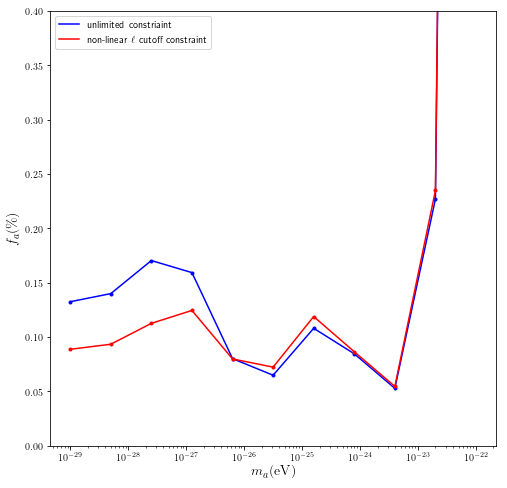

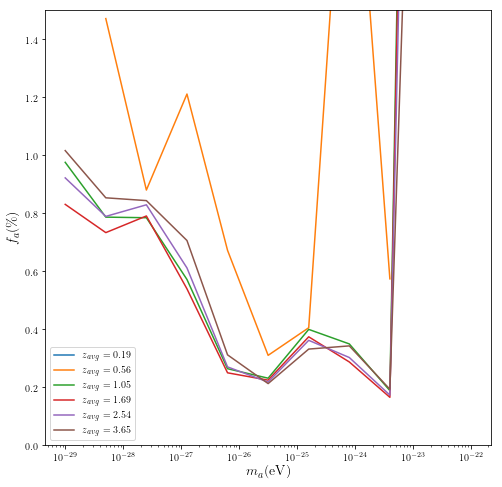

In [25]:
#fisher matrices for un-limited ("fisher") and ell-limited ("fisher2") cases -- added "fisher3" to look at auto-zbinning instead of trace
fisher = fsky * np.sum(ell_mod * np.trace(in_trace,axis1 = 4,axis2 = 5),axis = 1)
fisher2 = fsky * np.sum(ell_mod * np.trace(in_trace2,axis1 = 4,axis2 = 5),axis = 1)
fisher3 = fsky * np.sum(ell_mod3 * [np.transpose(in_trace,(4,5,0,1,2,3))[i][i] for i in range(6)],axis = 2)


diagonals = [[np.diag(fisher3[i][j]) for i in range(6)] for j in range(11)]
eigenvalues = [[np.linalg.eig(fisher3[i][j])[0] for i in range(6)] for j in range(11)]
condition = [[np.linalg.cond(fisher3[i][j]) for i in range(6)] for j in range(11)]
#print(eigenvalues)

# invert fisher matrices to find covariance matrices
covariance = cholesky_inverse(fisher)
covariance2 = cholesky_inverse(fisher2)
covariance3 = [np.linalg.inv(fisher3[i]) for i in range(6)]
comparison = [[np.matmul(covariance3[i][j],fisher3[i][j]) for i in range(6)] for j in range(11)]
#print(comparison)

# extract constraints from covariance matricies
constraints = [np.sqrt(np.diagonal(covariance[i])) for i in range(11)]
constraints2 = [np.sqrt(np.diagonal(covariance2[i])) for i in range(11)]
constraints3 = [[np.sqrt(np.diagonal(covariance3[i][j])) for j in range(11)] for i in range(6)]
#print(constraints3)

# isolate axion fraction constraints
fa = [constraints[i][2] for i in range(11)]
fa2 = [constraints2[i][2] for i in range(11)]
fa3 = [[constraints3[i][j][2] for j in range(11)] for i in range(6)]
#print(fa3)

# plot axion fraction constraints
plt.plot(ma,fa*np.asarray(100),color = 'b',label = r'unlimited constriaint')
plt.plot(ma,fa*np.asarray(100),'.',color = 'b')
plt.plot(ma,fa2*np.asarray(100),color = 'r',label = r'non-linear $\ell$ cutoff constraint')
plt.plot(ma,fa2*np.asarray(100),'.',color = 'r')
plt.xlabel(r'$m_a ({\rm eV})$',size = 14)
plt.ylabel(r'$f_a (\%)$',size = 14)
plt.xscale('log')
plt.ylim(0,0.4)
plt.legend()
plt.show()
plt.close('all')
# plt.savefig('constraint_cutoff.pdf')

for i in range(6):
    plt.plot(ma,fa3[i]*np.asarray(100),label = r'$z_{avg} = %s$'%(np.round(zavg[i],2)))
plt.xlabel(r'$m_a ({\rm eV})$',size = 14)
plt.ylabel(r'$f_a (\%)$',size = 14)
plt.xscale('log')
plt.ylim(0,1.5)
plt.legend()
# plt.savefig('constraint_autoz.pdf')
plt.show()


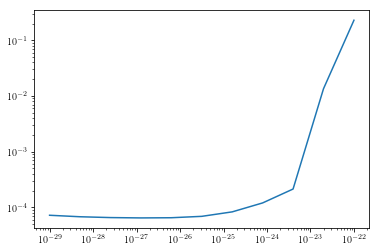

In [5]:
# # fisher3 fails above because the matrix is not positive definite (i.e. does not have all positive eigenvalues)
# print('lowest zbin not positive definite:',[np.linalg.eig(fisher3[0][i])[0] for i in range(11)])
# print('lowest zbin not positive definite:',[np.linalg.eig(fisher3[0][i])[0] for i in range(11)])
# print('cholesky required due to ill-conditioning:',np.linalg.cond(fisher3))
# print([np.diagonal(fisher3[0][i]) for i in range(11)])
test = [np.sqrt(1/np.diagonal(fisher3[1][i])[2]) for i in range(11)]
plt.loglog(ma,test)
#plt.xscale('log')
plt.show()

In [ ]:
# autoz = [np.transpose(in_trace,(4,5,0,1,2,3))[i][i] for i in range(np.shape(in_trace)[-1])]
# ellmod_auto = np.reshape(ell_mod,(1,1,2998,1,1))
# fisher_auto = fsky * np.sum(ellmod_auto * autoz, axis = 2)
# covariance_auto = np.linalg.inv(fisher_auto)
# print(np.shape(covariance_auto))
# constraints_auto = [[np.sqrt(np.diagonal(covariance_auto[i][j])) for j in range(11)] for i in range(6)]
# print(np.shape(constraints_auto))
# fa_auto = [[constraints_auto[i][j][2] for j in range(11)] for i in range(6)]
# for i in range(6):
#     plt.plot(ma,fa_auto[i])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

In [6]:
#functions for computing the ellipse axes and angle
def afunc(sx,sy,sxy):
    term1 = (np.square(sx)+np.square(sy))/2.
    term2 = (np.square(np.square(sx)-np.square(sy))/4.)+np.square(sxy)
    a = np.sqrt(term1+np.sqrt(term2))
    return a
def bfunc(sx,sy,sxy):
    term1 = (np.square(sx)+np.square(sy))/2.
    term2 = (np.square(np.square(sx)-np.square(sy))/4.)+np.square(sxy)
    b = -np.sqrt(np.abs(term1-np.sqrt(term2)))
    return b
def theta(sx,sy,sxy):
    th = np.arctan((2.*sxy)/(np.square(sx)-np.square(sy)))/2.
    return th

#computes the ellipse axes and angle
amat = []
bmat = []
thmat = []
# for g in range(6):
#     a1 = []
#     b1 = []
#     th1 = []
for i in range(9):
    a2 = []
    b2 = []
    th2 = []
    for j in range(5):
        a3 = []
        b3 = []
        th3 = []
        for y in range(5):
            a3.append(afunc(covariance2[i][j][j],covariance2[i][y][y],covariance2[i][j][y]))
            b3.append(bfunc(covariance2[i][j][j],covariance2[i][y][y],covariance2[i][j][y]))
            th3.append(theta(covariance2[i][j][j],covariance2[i][y][y],covariance2[i][j][y]))
        a2.append(a3)
        b2.append(b3)
        th2.append(th3)
#         a1.append(a2)
#         b1.append(b2)
#         th1.append(th2)
    amat.append(a2)
    bmat.append(b2)
    thmat.append(th2)

#converts the ellipse angle from radians to degrees (necessary for later plotting)
rad_to_deg = np.reshape(180./np.pi,(1,1,1))
deg_theta = thmat*rad_to_deg
print(np.shape(amat),np.shape(bmat),np.shape(thmat))

(9, 5, 5) (9, 5, 5) (9, 5, 5)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [7]:
# redshift list matching axionCAMB
zlist = np.linspace(0,4.5,301)
#fiducial parameter values as given in table 3 of Planck 2015 (arxiv 1502.01589)
fv = [0.02225,0.1198,0.0001,10**-27,67.27,0.9645]
#parameter confidence intervals as given in table 3 of Planck 2015 (arxiv 1502.01589)
ci = [0.00016,0.0015,'n/a','n/a',0.66,0.0049]
#number of axioncamb runs for each parameter
runs = 9
#run values for omega_baryon
omegab = np.round(np.linspace(fv[0]-ci[0],fv[0]+ci[0],runs),5)
#run values for omega_cdm
omegac = np.round(np.linspace(fv[1]-ci[1],fv[1]+ci[1],runs),4)
#run values for omega_cdm and omega_axion used to run the desired axion fractions
fa = np.linspace(0.0001,0.2,9)
omegaax = fv[1]*fa
omegac2 = fv[1]-omegaax
fa_zip = zip(omegac2,omegaax)
#run values for hubble constant
h0 = np.round(np.linspace(fv[4]-ci[4],fv[4]+ci[4],runs),2)
#run values for scalar tilt
ns = np.round(np.linspace(fv[5]-ci[5],fv[5]+ci[5],runs),4)
#run values for axion mass
ma = np.logspace(-29,-22,11)
params = []
params.append(omegab)
params.append(omegac)
params.append(fa)
params.append(ns)
params.append(h0)

1e-29
5.011872336272715e-29
2.511886431509572e-28
1.2589254117941712e-27
6.309573444801943e-27
3.162277660168379e-26
1.584893192461111e-25
7.943282347242789e-25
3.9810717055349856e-24


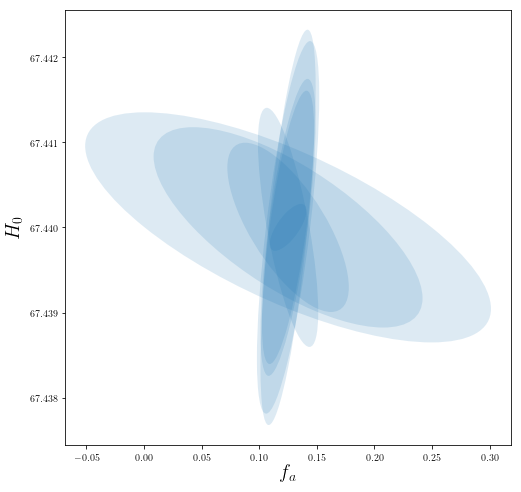

In [24]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

degen1 = 2
degen2 = 4
center = [params[degen1][5],params[degen2][5]]

param_names = [r'$\Omega_{b}$','$\Omega_{cdm}$','$f_a$','$n_s$','$H_0$']

fig,ax = plt.subplots()
for i in range(9):
    ells = Ellipse(xy=center, width=amat[i][degen1][degen2], height=bmat[i][degen1][degen2], angle = 180+deg_theta[i][degen1][degen2],alpha = 0.15)
    print(ma[i])
    ax.add_patch(ells)

ax.autoscale()
ax.set_xlabel(r'$%s$'%(param_names[degen1]),size = 20)
ax.set_ylabel(r'$%s$'%(param_names[degen2]),size = 20)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()